#  <center> ISEL </center>
#  <center> Licenciatura em Matemática Aplicada à Tecnologia e à Empresa </center>
## <center> Introdução à Análise Numérica </center>
##  <center> 2º Semestre 2022/23</center>

# <center> Trabalho Computacional - Grupo 2 <center>
    
 <div style="text-align: right"> Rodrigo Macau - 50841 </div>
 <div style="text-align: right"> Mariana Silva - 48587 </div>
 <div style="text-align: right"> Ana Lopes     - 50855 </div>
                                          

Antes de dármos início ao nosso trabalho, temos de saber quais são as ferramentas que temos de usar. Como estamos perante um estudo exploratório da variação da temperatura de Bragança teremos de analisar vários dados. Para tal, usamos a biblioteca "pandas" que é utilizada para ler os dados de temperatura dos arquivos CSV e armazená-los em estruturas de dados.

Também utilizamos a biblioteca 'numpy', de forma a criar e manipular os arrays NumPy que armazenam os valores de temperatura mínima, máxima, range, mean e desvio padrão (STD).

E a última biblioteca é o 'matplotlib.pyplot' que será utilizado para plotar os dados de temperatura e as curvas ajustadas pelos splines. Esta é a que serve para a visualização de gráficos que, neste contexto, nos ajudam a observar as variações de temperatura ao longo do tempo. 

# Pergunta 1 
### Utilize Splines Lineares e Cúbicos para representar toda a informação disponibilizada nos dados. Escolha de forma adequada as condições de fronteira utilizadas nos Splines Cúbicos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Como já temos as ferramentas necessárias passamos à fase seguinte, ou seja, à leitura dos dados:

In [2]:
df_min = pd.read_csv('https://api.ipma.pt/open-data/observation/climate/temperature-min/braganca/mtnmn-0402-braganca.csv')
df_min.head()
df_max = pd.read_csv('http://api.ipma.pt/open-data/observation/climate/temperature-max/santarem/mtxmx-1401-abrantes.csv')
df_max.head()

,date,minimum,maximum,range,mean,std
0,2023-03-02,16.607178,17.400000,0.792822,17.104683,0.201980
1,2023-03-03,17.831884,18.900000,1.068115,18.472788,0.303470
2,2023-03-04,16.609287,18.099998,1.490711,17.481529,0.467743
3,2023-03-05,12.093432,13.754199,1.660767,12.633902,0.445888
4,2023-03-06,15.412357,16.199999,0.787642,15.939786,0.157309


O código anterior faz a leitura de dois conjuntos de dados de temperatura a partir de arquivos CSV diferentes. Utilizamos a função 'pd.read_csv' da biblioteca 'pandas' para ler os arquivos diretamente do site do IPMA de modo a manter os dados atualizados ao minuto. Estes são lidos e armazenados em dois DataFrames: df_min e df_max.

Passemos então à fase da extração de dados:

In [3]:
dates = np.arange(len(df_min))

temp_minmin = df_min['minimum'].to_numpy()
temp_minmax = df_min['maximum'].to_numpy()
temp_minrange = df_min['range'].to_numpy()
temp_minmean = df_min['mean'].to_numpy()
temp_minstd = df_min['std'].to_numpy()

temp_maxmin = df_max['minimum'].to_numpy()
temp_maxmax = df_max['maximum'].to_numpy()
temp_maxrange = df_max['range'].to_numpy()
temp_maxmean = df_max['mean'].to_numpy()
temp_maxstd = df_max['std'].to_numpy()

O código extrai as colunas necessárias dos DataFrames e armazena-as em diferentes arrays do NumPy. Esses arrays são, por exemplo, a 'temp_minmin', 'temp_minmax', 'temp_minrange', 'temp_minmean', 'temp_minstd', (os mesmos códigos para os dados da temperatura máxima). Utilizamo-los para armazenar os dados de temperatura mínima e máxima, bem como outras métricas relacionadas, como o range, mean e o desvio padrão (STD). 

Visto que já temos os dados necessários acerca das temperaturas, passamos à implementação da classe splines com condições naturais que está disposta na aula prática 8 em pdf no moodle da UC.

In [4]:
class NaturalSpline:
    def __init__(self,data_x,data_y):
        self.x=data_x
        self.y=data_y
        self.N=len(data_x)-1
        assert len(self.x) != 0 and (len(self.x) == len(self.y)),\
        'x and y cannot be empty and must have the same length'
        self.h=data_x[1:self.N+1]-data_x[0:self.N]
        self.a=self.y
        self.b=np.zeros(self.N)
        self.c=np.zeros(self.N+1)
        self.d=np.zeros(self.N)
        self.Amat=np.zeros((self.N+1,self.N+1))
        self.SetAMatValues()
        self.Bvec=np.zeros(self.N+1)
        self.SetBvecValues()
        self.SolveSystem()
        self.Setbdvalues()
        
    def SetAMatValues(self):
        self.Amat[0][0]=1.0
        self.Amat[self.N][self.N]=1.0
        for i in range(1,self.N):
            self.Amat[i][i-1]=self.h[i-1]
            self.Amat[i][i]=2.0*(self.h[i-1]+self.h[i])
            self.Amat[i][i+1]=self.h[i]
    
    def SetBvecValues(self):
        for i in range(1,self.N):
                self.Bvec[i]=3.0*(self.a[i+1]-self.a[i])/self.h[i] -3.*(self.a[i]-self.a[i-1])/self.h[i-1] 

    def SolveSystem(self): 
        self.c=np.linalg.solve(self.Amat,self.Bvec)

    def Setbdvalues(self):
        self.b[0:self.N]=(self.a[1:self.N+1]-self.a[0:self.N])/self.h[0:self.N]\
                         -self.h[0:self.N]/3.0*(2*self.c[0:self.N]+self.c[1:self.N+1])
            
        self.d[0:self.N]=(self.c[1:self.N+1]-self.c[0:self.N])/(3.0*self.h[0:self.N])
    
    def Si(self,i,varx):
        return self.a[i]+self.b[i]*(varx-self.x[i])+self.c[i]*(varx-self.x[i])**2+self.d[i]*(varx-self.x[i])**3
    
    def SplineFunction(self,varx):
        M=len(varx)
        assert self.x[0] == varx[0] and varx[M-1] == self.x[self.N], 'varx must be inside [x_0,x_n]'
        aux=np.zeros(M)
        for j in range(0,M-1): 
            for i in range(0,self.N):
                if self.x[i]<= varx[j] < self.x[i+1]:
                    aux[j]=self.Si(i,varx[j])
                    break
                    
        aux[M-1]=self.Si(self.N-1,varx[M-1])
        
        return aux


A classe 'NaturalSpline' define uma função spline cúbico natural. Um spline é uma curva que é construída a partir de polinómios. Esta classe implementa splines que são usados para interpolar uma função entre pontos de dados.

A interpolação spline cúbico natural envolve a criação de polinómios de terceiro grau que se ajustam aos pontos de dados fornecidos, garantindo que a curva resultante seja suave e tenha derivadas contínuas, já a interpolação spline linear envolve a criação de polinómios de segundo grau.

A classe 'NaturalSpline' dispõe a lógica necessária para criar e avaliar splines cúbicos naturais. Permite interpolar os pontos de dados e obter valores intermédios para uma função definida pelos pontos fornecidos. É bastante útil no nosso trabalho e em várias outras aplicações futuramente pois representa curvas em gráficos ou a estimativa de valores desconhecidos entre pontos de dados conhecidos.

Agora que já temos disposta a nossa classe, vamos criar um intervalo de valores para a plotagem  dos dados:

In [30]:
x = np.linspace(dates[0], dates[-1], 1000)

Criámos um array x utilizando a função 'np.linspace', de modo a gerar um intervalo de valores, esse intervalo é importante pois será usado para plotar as curvas de spline de forma suave e contínua.

A plotagem é uma técnica para visualizar dados e comunicar informações de maneira clara e eficaz. Esta ajuda a explorar dados, identificar padrões e é a mesma que cria imagens através de desenhos de linhas ou de traços.

Neste trabalho existem vários dados/variáveis diferentes, como o minimum, maximum, range, mean e std. Daí, uma instância pode ser criada para interpolar os pontos de dados da temperatura mínima, enquanto outra instância pode ser criada para interpolar os pontos de dados da temperatura máxima. Cada uma destas variáveis é representada por um array de dados separado, daí o código acima.

Essas instâncias individuais podem ser usadas posteriormente para avaliar a curva de spline e obter valores interpolados para diferentes pontos ou intervalos de interesse dentro do conjunto de dados de temperatura original.

Com esta informação procedemos à plotagem dos dados e das curvas de spline (interpolação linear):

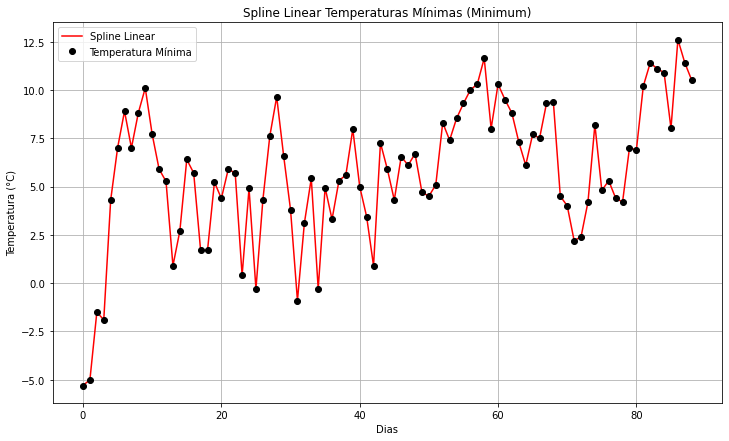

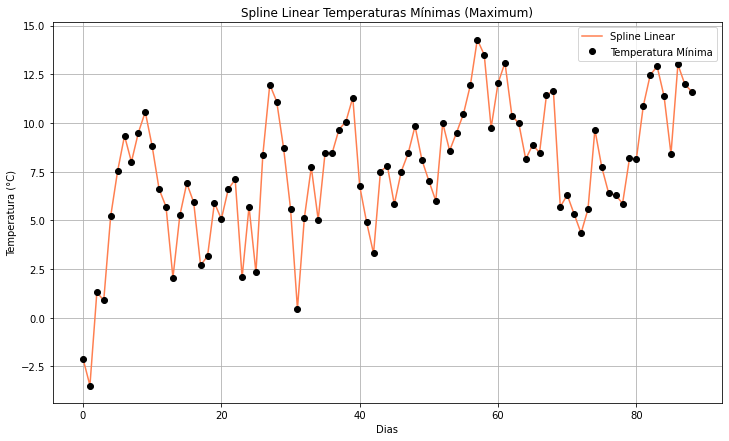

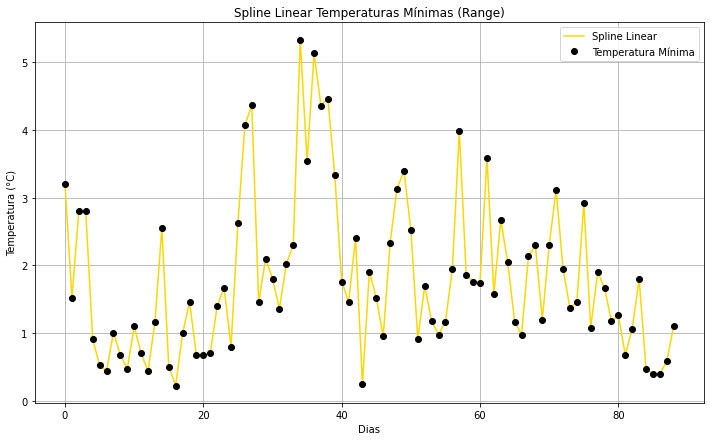

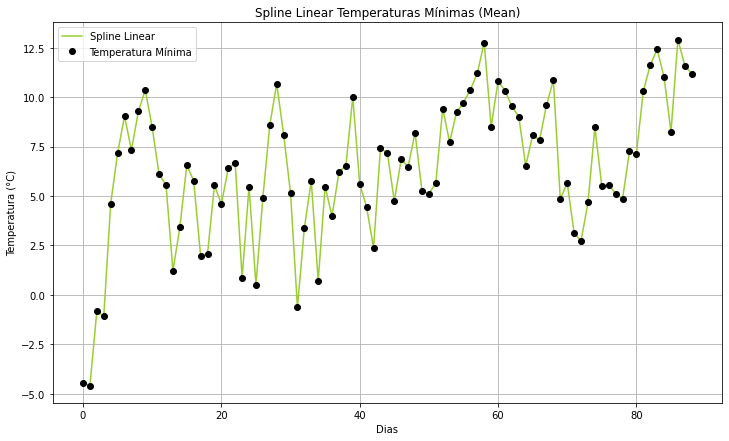

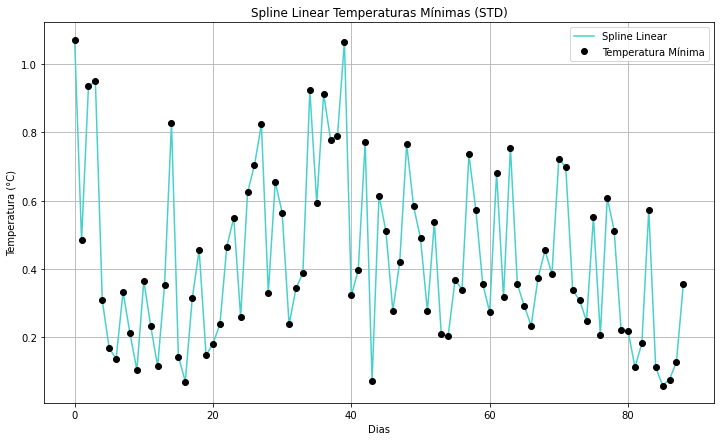

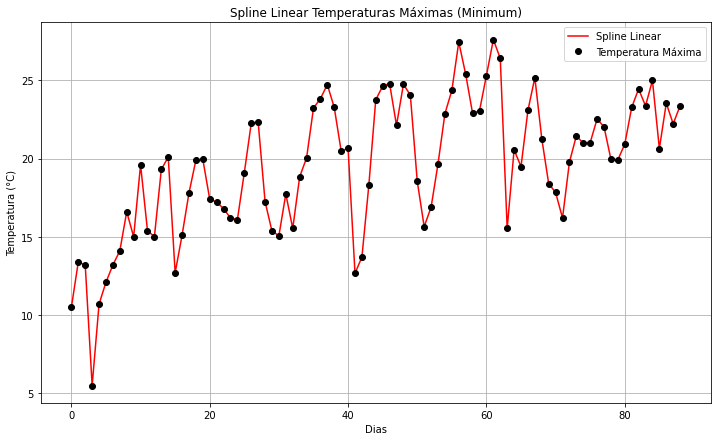

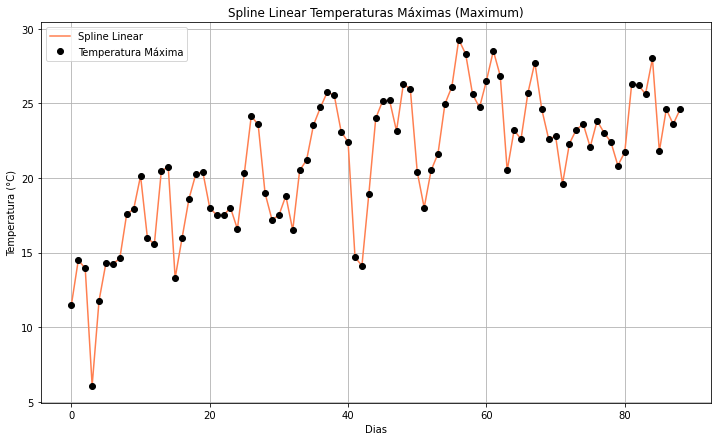

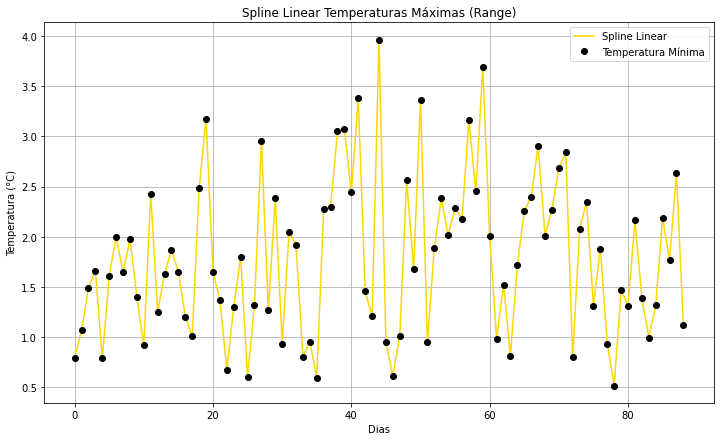

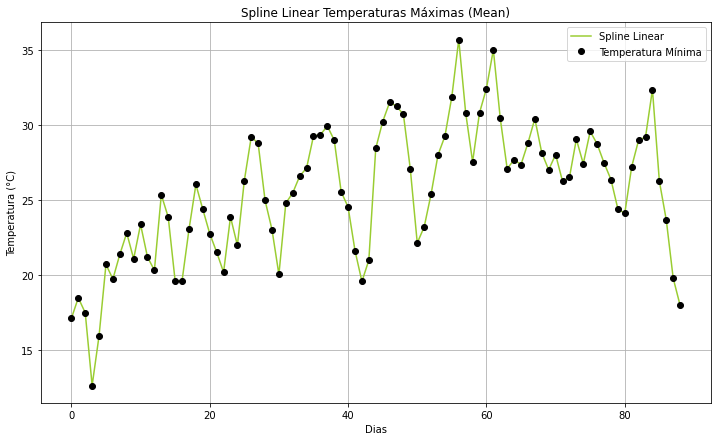

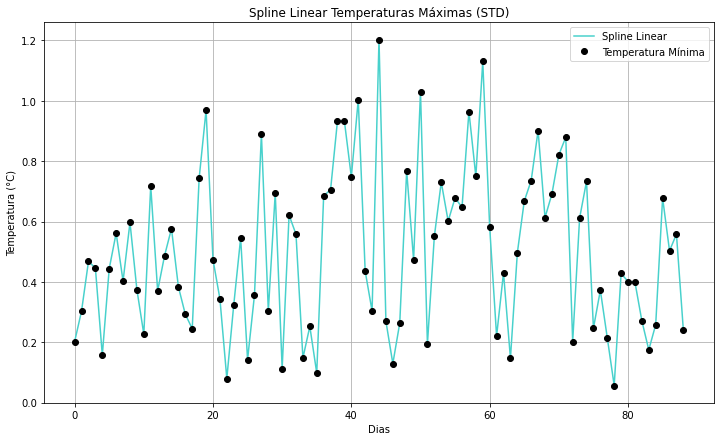

In [31]:
plt.figure(figsize = (12,7))

plt.plot(dates, temp_minmin, '-', label='Spline Linear',color='red')
plt.plot(dates, temp_minmin, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Mínimas (Minimum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_minmax, '-', label='Spline Linear',color='coral')
plt.plot(dates, temp_minmax, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Mínimas (Maximum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_minrange, '-', label='Spline Linear',color='gold')
plt.plot(dates, temp_minrange, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Mínimas (Range)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_minmean, '-', label='Spline Linear',color='yellowgreen')
plt.plot(dates, temp_minmean, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Mínimas (Mean)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_minstd, '-', label='Spline Linear',color='mediumturquoise')
plt.plot(dates, temp_minstd, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Mínimas (STD)')
plt.grid()
plt.show()


plt.figure(figsize = (12,7))
plt.plot(dates, temp_maxmin, '-', label='Spline Linear',color='red')
plt.plot(dates, temp_maxmin, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Máximas (Minimum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_maxmax, '-', label='Spline Linear',color='coral')
plt.plot(dates, temp_maxmax, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Máximas (Maximum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_maxrange, '-', label='Spline Linear', color='gold')
plt.plot(dates, temp_maxrange, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Máximas (Range)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_maxmean, '-', label='Spline Linear',color='yellowgreen')
plt.plot(dates, temp_maxmean, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Máximas (Mean)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(dates, temp_maxstd, '-', label='Spline Linear',color='mediumturquoise')
plt.plot(dates, temp_maxstd, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Linear Temperaturas Máximas (STD)')
plt.grid()
plt.show()

Como já explicámos anteriormente, resumidamente, a plotagem é a técnica/ferramenta que cria imagens através de desenhos de linhas ou de traços. 

O código acima faz a plotagem dos pontos de dados originais e das curvas de spline correspondentes para cada medida de temperatura. Utilizamos a função 'plt.plot' para criar os gráficos e cada gráfico é exibido separadamente utilizando a função plt.show(). São plotados tanto os pontos de dados quanto as curvas de spline obtidas a partir desses pontos.

A inicialização das instâncias da classe NaturalSpline refere-se à criação de objetos individuais da classe para cada array de dados de temperatura. 
Visto isto vamos então retornar à classe e criar instâncias da mesma:

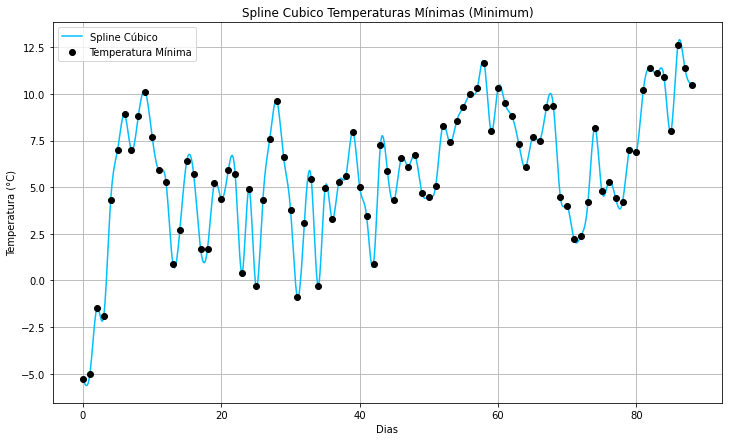

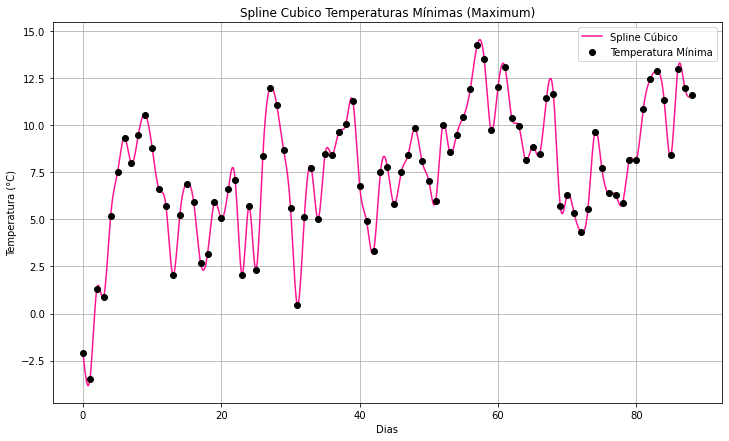

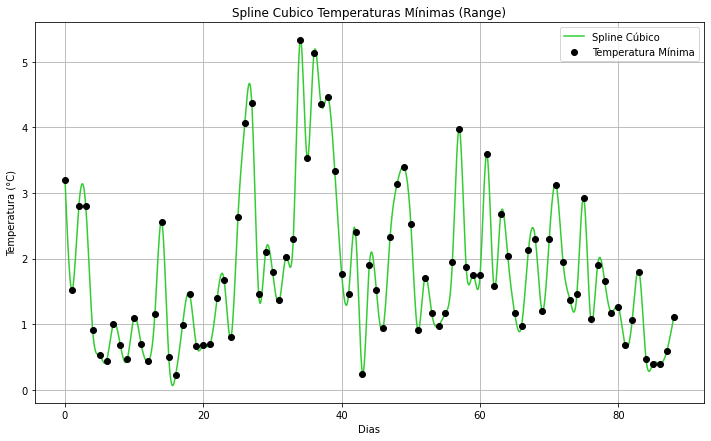

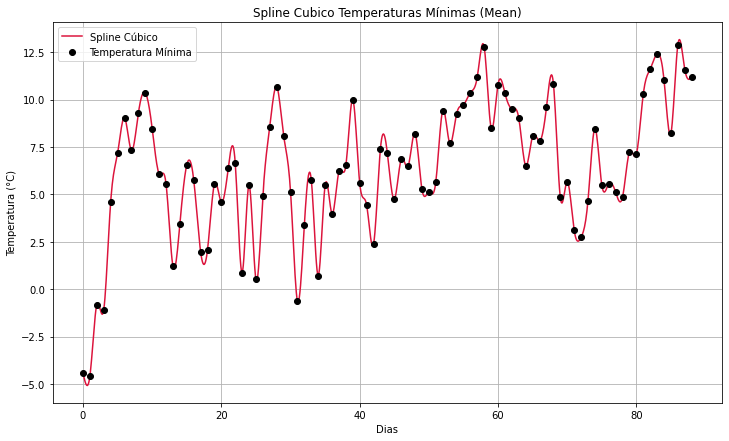

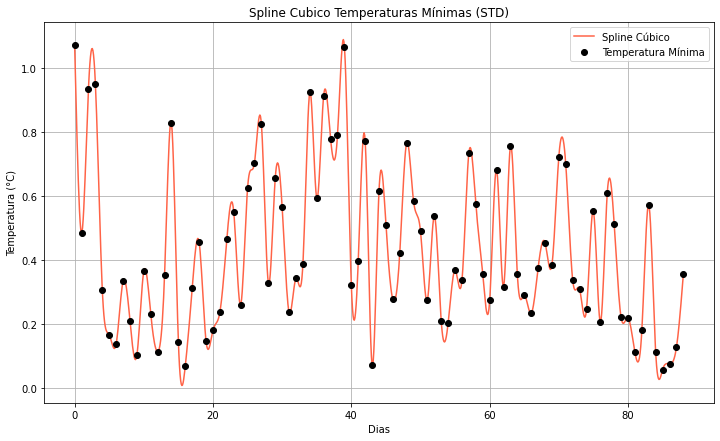

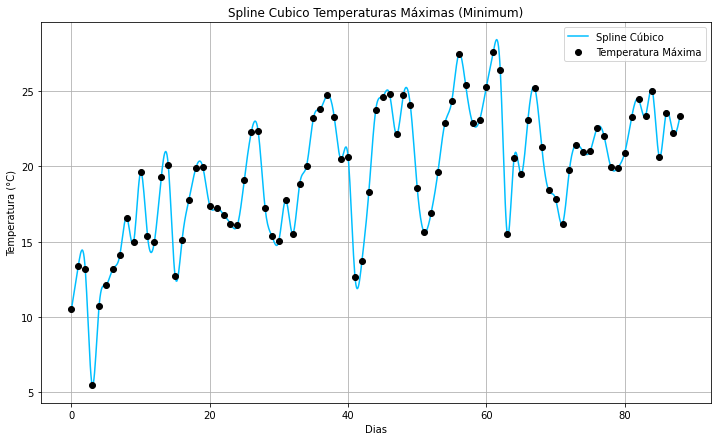

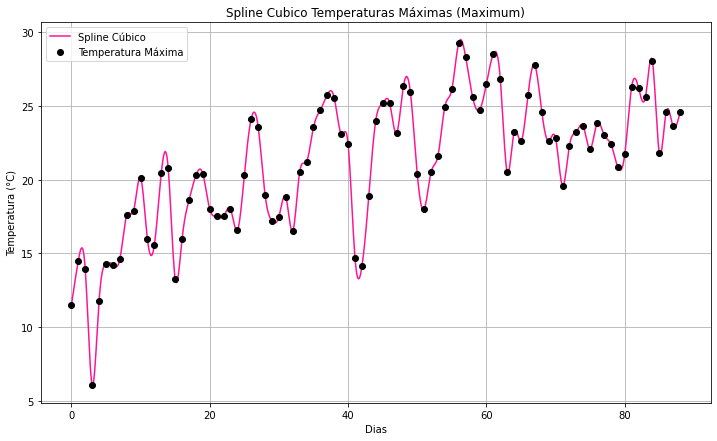

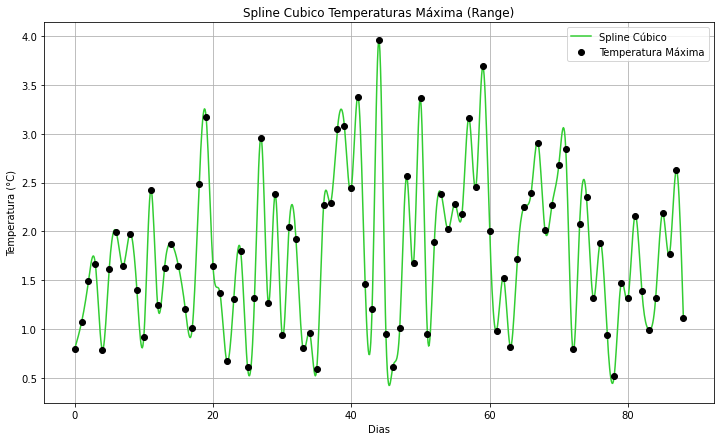

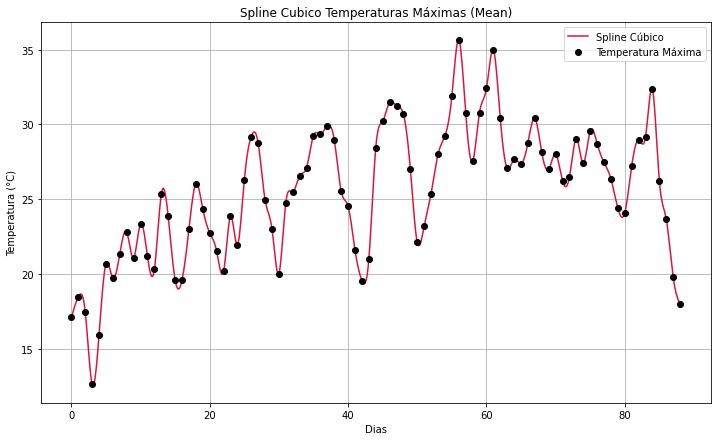

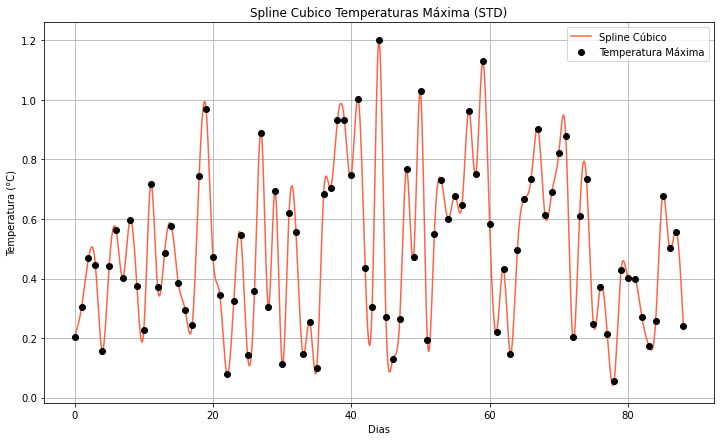

In [38]:
spline_minmin = NaturalSpline(dates, temp_minmin)
spline_minmax = NaturalSpline(dates, temp_minmax)
spline_minrange = NaturalSpline(dates, temp_minrange)
spline_minmean =NaturalSpline(dates, temp_minmean)
spline_minstd =NaturalSpline(dates, temp_minstd)

spline_maxmin = NaturalSpline(dates, temp_maxmin)
spline_maxmax = NaturalSpline(dates, temp_maxmax)
spline_maxrange = NaturalSpline(dates, temp_maxrange)
spline_maxmean = NaturalSpline(dates, temp_maxmean)
spline_maxstd = NaturalSpline(dates, temp_maxstd)

plt.figure(figsize = (12,7))
plt.plot(x, spline_minmin.SplineFunction(x), '-', label='Spline Cúbico', color = 'deepskyblue')
plt.plot(dates, temp_minmin, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Mínimas (Minimum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_minmax.SplineFunction(x), '-', label='Spline Cúbico', color = 'deeppink')
plt.plot(dates, temp_minmax, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Mínimas (Maximum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_minrange.SplineFunction(x), '-', label='Spline Cúbico', color = 'limegreen')
plt.plot(dates, temp_minrange, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Mínimas (Range)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_minmean.SplineFunction(x), '-', label='Spline Cúbico', color = 'crimson')
plt.plot(dates, temp_minmean, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Mínimas (Mean)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_minstd.SplineFunction(x), '-', label='Spline Cúbico', color = 'tomato')
plt.plot(dates, temp_minstd, 'ok', label='Temperatura Mínima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Mínimas (STD)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_maxmin.SplineFunction(x), '-', label='Spline Cúbico', color = 'deepskyblue')
plt.plot(dates, temp_maxmin, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Máximas (Minimum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_maxmax.SplineFunction(x), '-', label='Spline Cúbico', color = 'deeppink')
plt.plot(dates, temp_maxmax, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Máximas (Maximum)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_maxrange.SplineFunction(x), '-', label='Spline Cúbico', color = 'limegreen')
plt.plot(dates, temp_maxrange, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Máxima (Range)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_maxmean.SplineFunction(x), '-', label='Spline Cúbico', color = 'crimson')
plt.plot(dates, temp_maxmean, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Máximas (Mean)')
plt.grid()
plt.show()

plt.figure(figsize = (12,7))
plt.plot(x, spline_maxstd.SplineFunction(x), '-', label='Spline Cúbico', color = 'tomato')
plt.plot(dates, temp_maxstd, 'ok', label='Temperatura Máxima')
plt.legend()
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.title('Spline Cubico Temperaturas Máxima (STD)')
plt.grid()
plt.show()

O processo de plotagem é repetido, mas desta vez utilizámos a interpolação cúbica de spline.

Os gráficos são gerados para os mesmos dados de temperatura (minimum, maximum, range, mean, std), porém, utilizámos a interpolação cúbica para além da interpolação linear pois é esta que nos permite estimar os valores de temperatura para pontos de tempo especificos que não estão presentes nos dados originais. Desta forma teremos um gráfico mais harmonioso pois é a interpolação cúbica que cria curvas suaves e contínuas que representam a variação da temperatura ao longo do tempo, mesmo para períodos em que não tenhamos dados disponíveis.

# Pergunta 2
### A partir da informação sobre as temperaturas mínimas e máximas, descreva graficamente a variação da temperatura média no mesmo período. Utilize o método dos mínimos quadrados para determinar funções de ajustamento para a temperatura média. Indique os erros totais obtidos pelo método dos mínimos quadrados e os dias em que os erros são mínimos e máximos. Comece por determinar a recta de ajustamento e complemente o estudo com outras possíveis funções de ajustamento.

Tal como na pergunta 1, repetimos o mesmo processo de abertura das bibliotecas necessárias para que possamos manipular e visualizar os dados.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Após isto, exatamente como na pergunta 1, começamos por ler os dados de temperatura mínima e máxima de Bragança. Utilizamos a função 'pd.read_csv()' do pandas para ler os dados dos arquivos CSV:

In [9]:
df_min = pd.read_csv('https://api.ipma.pt/open-data/observation/climate/temperature-min/braganca/mtnmn-0402-braganca.csv')
df_min.head()
df_max = pd.read_csv('https://api.ipma.pt/open-data/observation/climate/temperature-max/braganca/mtxmx-0402-braganca.csv')
df_max.head()

,date,minimum,maximum,range,mean,std
0,2023-03-02,10.500001,11.499855,0.999854,10.809868,0.333024
1,2023-03-03,13.400001,14.499775,1.099774,13.715704,0.364634
2,2023-03-04,13.200001,13.940175,0.740174,13.412250,0.211365
3,2023-03-05,5.500001,6.094169,0.594168,5.711302,0.179838
4,2023-03-06,10.700002,11.785197,1.085196,11.073249,0.352371


In [10]:
dates = np.arange(len(df_min))

Em seguida, extraímos os dados da temperatura mínima e máxima dos DataFrames 'df_min' e 'df_max'. Acedemos às colunas "minimum" e "maximum" dos DataFrames e convertemos os dados em arrays usando o método 'to_numpy()', como se pode verificar no código abaixo. Assim temos os dados de temperatura mínima em temp_minmin e temp_maxmin, e os dados de temperatura máxima em temp_minmax e temp_maxmax.

In [11]:
temp_minmin = df_min['minimum'].to_numpy()
temp_minmax = df_min['maximum'].to_numpy()
temp_maxmin = df_max['minimum'].to_numpy()
temp_maxmax = df_max['maximum'].to_numpy()

Visto isto, vamos agora ajustar uma reta aos dados de temperatura mínima para obtermos uma estimativa da temperatura média ao longo do tempo. Criamos então uma equação para a temperatura média mínima que será a seguinte:

In [12]:
temperatura_media_min = (temp_minmin + temp_minmax) / 2

Após este processo damos inicio à implementação do método dos minimos quadrados que encontra a linha reta que minimiza a soma dos quadrados dos erros, onde estes indicam as diferenças entre os valores observados e os valores estimados pela reta.

Realizámos assim o ajuste de uma reta, que denominámos por 'y_reta', aos dados de temperatura mínima. Para tal utilizámos o 'np.polyfit()' cujo é o método de ajuste polinomial que encontra os coeficientes de um polinômio que melhor se ajusta aos dados fornecidos.

Neste caso específico, o objetivo é encontrar os coeficientes que definem a equação da reta, ou seja, o coeficiente angular (inclinação) e o coeficiente linear (interseção).

Uma vez que os coeficientes da reta são encontrados, podemos utilizar essa mesma reta ajustada para fazer previsões ou estimar valores intermediários da temperatura mínima com base no tempo.

In [13]:
coef = np.polyfit(dates, temp_minmin, 1)
a, b = coef
x = np.linspace(dates[0], dates[-1], 1000)
y_reta = np.polyval(coef, x)

De seguida calculámos os erros entre a temperatura média e a reta ajustada de forma a avaliar o quão bem a reta se ajusta aos dados reais e determinar o quão bem a reta representa a tendência dos dados de temperatura média. Para calcular o erro basta subtrair os valores da reta ajustada da temperatura média e é essa subtração que nos dá um array de erros para cada dia.

Aplicámos a função np.abs() para obter os valores absolutos dos erros, eliminando qualquer sinal negativo que apareça.

Calculamos o erro total somando todos os erros absolutos.

Para encontrar o dia com o menor e o maior erro, utilizámos as funções 'np.argmin()' e 'np.argmax()' para encontrar os índices dos valores mínimo e máximo dos erros absolutos. 

In [14]:
erros = temperatura_media_min - np.polyval(coef, dates)
dia_min_erro = dates[np.argmin(np.abs(erros))]
dia_max_erro = dates[np.argmax(np.abs(erros))]
erro_total = np.sum(np.abs(erros))

Após já termos os coeficientes da reta de ajuste e os erros entre os valores observados e estimados, chegamos à etapa de visualização dos resultados por meio de um gráfico.

Nesse caso, por fim plotamos um gráfico para visualizar os dados de temperatura média mínima e a reta de ajuste. Utilizamos o método 'plt.plot()' para traçar os pontos de temperatura média e a reta de ajuste, e adicionamos rótulos e legendas para melhorar a compreensão do gráfico.

Exibimos o gráfico com a função 'plt.show():

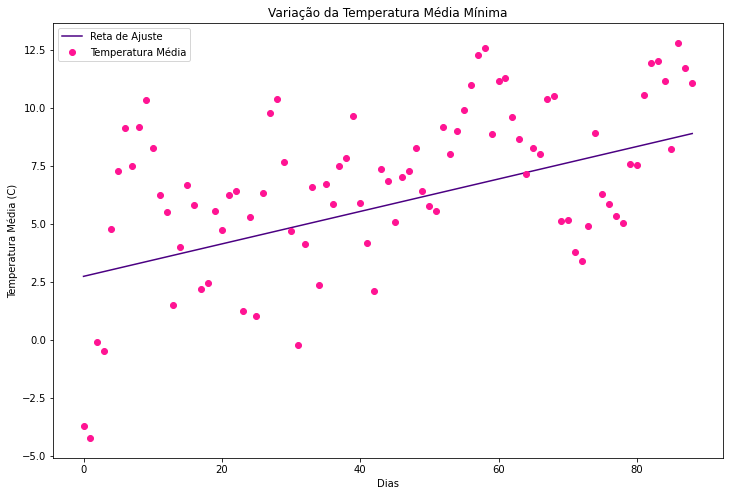

Função de Ajuste: Temperatura Média = 0.07 * Dias + 2.73
Erro Total: 232.12
Dia com Menor Erro: 64
Dia com Maior Erro: 1


In [51]:
plt.figure(figsize=(12, 8))
plt.plot(x, y_reta, '-', label='Reta de Ajuste', color = 'indigo')
plt.plot(dates, temperatura_media_min, 'o', label='Temperatura Média',color='deeppink')
plt.xlabel('Dias')
plt.ylabel('Temperatura Média (C)')
plt.title('Variação da Temperatura Média Mínima')
plt.legend()
plt.show()

print("Função de Ajuste: Temperatura Média = {:.2f} * Dias + {:.2f}".format(a, b))
print("Erro Total: {:.2f}".format(erro_total))
print("Dia com Menor Erro: {}".format(dia_min_erro))
print("Dia com Maior Erro: {}".format(dia_max_erro))

Visto isto, vamos agora ajustar uma reta aos dados de temperatura máxima tal como fizemos acima para as temperaturas minimas. Criamos então uma equação para a temperatura média máxima que será a seguinte:

In [16]:
temperatura_media_max = (temp_maxmin + temp_maxmax) / 2

Após isso realizámos o ajuste da tal reta que mencionámos anteriormente e  que denominámos por 'y_reta_max', aos dados de temperatura máxima. A explicação é a mesma da anterior acerca do ajuste da reta 'y_reta', a reta de ajuste de temperaturas mínimas.

In [17]:
coef_max = np.polyfit(dates, temp_maxmin, 1)
a_max, b_max = coef_max

x_max = np.linspace(dates[0], dates[-1], 1000)
y_reta_max = np.polyval(coef_max, x_max)

De seguida calculámos os erros da reta ajustada de forma a avaliar o quão bem a reta se ajusta aos dados reais e determinar o quão bem a reta representa a tendência dos dados de temperatura média:

In [18]:
erros_max = temperatura_media_max - np.polyval(coef_max, dates)
dia_min_erro_max = dates[np.argmin(np.abs(erros_max))]
dia_max_erro_max = dates[np.argmax(np.abs(erros_max))]
erro_total_max = np.sum(np.abs(erros_max))

Tal como anteriormente vamos agora criar/plotar um gráfico mas desta vez para as temperaturas máximas:

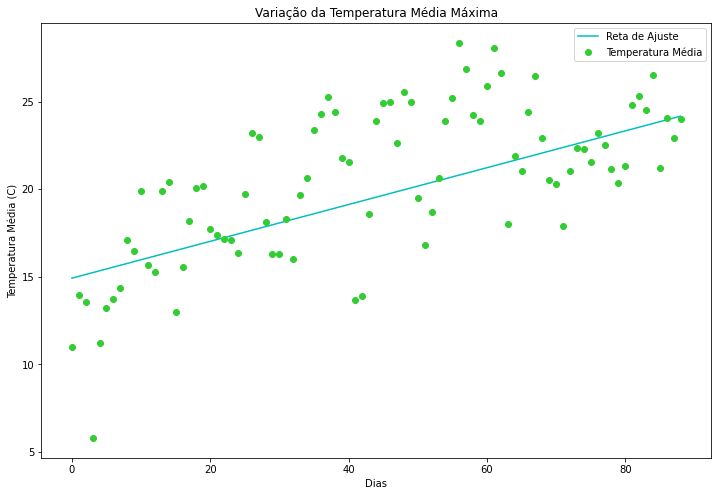

Função de Ajuste: Temperatura Média = 0.11 * Dias + 14.92
Erro Total: 236.96
Dia com Menor Erro: 22
Dia com Maior Erro: 3


In [54]:
plt.figure(figsize=(12, 8))
plt.plot(x_max, y_reta_max, '-', label='Reta de Ajuste',color ='c')
plt.plot(dates, temperatura_media_max, 'o', label='Temperatura Média',color='limegreen')
plt.xlabel('Dias')
plt.ylabel('Temperatura Média (C)')
plt.title('Variação da Temperatura Média Máxima')
plt.legend()
plt.show()

print("Função de Ajuste: Temperatura Média = {:.2f} * Dias + {:.2f}".format(a_max, b_max))
print("Erro Total: {:.2f}".format(erro_total_max))
print("Dia com Menor Erro: {}".format(dia_min_erro_max))
print("Dia com Maior Erro: {}".format(dia_max_erro_max))

##  <center> Conclusão do Trabalho: </center>


No trabalho proposto, começámos por utilizar os dados de temperaturas mínimas e máximas de Bragança, para realizar interpolação por meio de splines cúbicos e lineares.

Na primeira pergunta, através da implementação da classe "NaturalSpline", aprendemos a calcular os coeficientes necessários para a interpolação spline e a utilizar esses coeficientes para gerar curvas. Além disso, adquirimos conhecimentos sobre as diferenças entre splines cúbicos e lineares. Os splines cúbicos oferecem maior flexibilidade na modelação dos dados, tornando assim os gráficos mais harmoniosos. 

Na segunda pergunta utilizámos o método de ajuste de curva, denominado de 'polyfit' do pacote Numpy. Foram ajustadas retas aos dados de temperatura mínima e máxima utilizando o método dos minimos quadrados de forma a representar a tendência das temperaturas ao longo do tempo. 

Ao criármos os gráficos visualizámos a variação da temperatura média, juntamente com as retas de ajuste. Também identificámos o erro total do ajuste e os dias com menor e maior erro.

Aprendemos que é possível utilizar técnicas de ajuste de curva, como a interpolação polinomial, para estimar valores intermédios e suavizar conjuntos de dados. Além disso, a visualização dos dados através de gráficos ajuda na compreensão das tendências e padrões presentes nas informações.


